Following: https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Conv1D, \
                                    MaxPooling1D, Flatten, Reshape, \
                                    BatchNormalization, Dropout, add

from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, SGD

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
from src.keras_bert import convert_text_to_examples, \
                           create_tokenizer_from_hub_module, \
                           convert_examples_to_features, \
                           initialize_vars, \
                           BertLayer

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [6]:
# Initialize session
sess = tf.compat.v1.Session()

#### Custom Functions

In [7]:
from src.callbacks import PlotCurvesTF as PlotCurves
from src.eval_metrics import f1_micro, f1_macro
from src.load_data import load_data

### Load Data

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [9]:
batch_size = 32
max_seq_length = 512
if max_seq_length > 512:
    print('!!!!!!! WARNING: BERT does not accept lenght > 512. It is set to 512.')
    max_seq_length = 512

In [10]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [11]:
def get_input(data_, max_seq_length,
              bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    tokenizer = create_tokenizer_from_hub_module(bert_path)
    
    # !!! For BERT input, each sentence should be in an array
    X = np.array([[" ".join(sentence['sentence'].replace('\n', '').strip().split()[0:max_seq_length])]
                  for article in data_ 
                  for sentence in article['sentences']], dtype=object)

    y = [sentence['label'] 
         for article in data_
         for sentence in article['sentences']]
    
    examples_ = convert_text_to_examples(X, y)
    
    (input_ids, input_masks, segment_ids, labels_) = \
            convert_examples_to_features(tokenizer, examples_, max_seq_length=max_seq_length)

    return [input_ids, input_masks, segment_ids], labels_

In [12]:
X_tra, y_tra = get_input(train_data, max_seq_length)
X_val, y_val = get_input(valid_data, max_seq_length)
# X_test, y_test = get_input(test_data, max_seq_length)

W0908 22:53:40.766395 139980250632320 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Converting examples to features: 100%|██████████| 399/399 [00:00<00:00, 2563.14it/s]


## Build Model

In [13]:
def build_model_0(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    
    pred = Dense(1, activation='sigmoid')(bert_output)

    return Model(inputs=bert_inputs, outputs=pred)

In [14]:
def build_model_1(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    
    x = Dense(256)(bert_output)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [15]:
def build_model_2(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    def residual(x):
        x_res = x
        
        x = Dense(256)(x)
        x = Activation('relu')(x)

        x = add([x, x_res])
        return x
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    
    x = Dense(256)(bert_output)
    x = Activation('relu')(x)
    
    x = residual(x)
    
    x = Dense(256)(x)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [16]:
def build_model_3(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    bert_output = Reshape((768, 1))(bert_output)
    
    x = Conv1D(64, 5, padding='same')(bert_output)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Conv1D(64, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)
    
    x = Dense(256)(x)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [17]:
def build_model_4(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    bert_output = Reshape((768, 1))(bert_output)
    
    x = Conv1D(128, 5, padding='same')(bert_output)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Conv1D(128, 5, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)
    
    x = Dense(256)(x)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [18]:
def build_model_5(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    
    x = Dense(256)(bert_output)
    x = Activation('relu')(x)
    
    x = Dense(128)(bert_output)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [19]:
def build_model_6(max_seq_length, n_fine_tune_layers=3,
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    def residual(x):
        x_res = x

        x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(x)
        x = Activation('relu')(x)

        x = add([x, x_res])
        return x
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    bert_output = Reshape((768, 1))(bert_output)

    x = Conv1D(64, 5, padding='same')(bert_output)
    x = Activation('relu')(x)
    x = MaxPooling1D(5)(x)

    x = residual(x)
    x = MaxPooling1D(5)(x)

    x = Flatten()(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)

    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [20]:
def build_model_7(max_seq_length, n_fine_tune_layers=3, 
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    bert_output = Reshape((768, 1))(bert_output)
    
    x = Conv1D(64, 5, padding='same')(bert_output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = MaxPooling1D(5)(x)
    
    x = Conv1D(64, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = MaxPooling1D(5)(x)
    
    x = Flatten()(x)
    
    x = Dense(256)(x)
    x = Activation('relu')(x)
    
    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [30]:
def build_model_8(max_seq_length, n_fine_tune_layers=3,
                  bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):
    
    def residual(x):
        x_res = x

        x = Conv1D(64, 5, padding='same')(bert_output)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = add([x, x_res])
        return x
    
    bert_inputs = [Input(shape=(max_seq_length,), name="input_ids"),
                   Input(shape=(max_seq_length,), name="input_masks"),
                   Input(shape=(max_seq_length,), name="segment_ids")]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune_layers, 
                            pooling='mean', bert_path=bert_path)(bert_inputs)
    bert_output = Reshape((768, 1))(bert_output)

    x = Conv1D(64, 5, padding='same')(bert_output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual(x)
    x = MaxPooling1D(5)(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)

    pred = Dense(1, activation='sigmoid')(x)

    return Model(inputs=bert_inputs, outputs=pred)

In [31]:
tuned_layers = 3
learningrate = 2e-5 #0.001 # 0.01
optimizer = Adam(lr=learningrate)
optimizer_str = 'Adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [32]:
model = build_model_8(max_seq_length, n_fine_tune_layers=tuned_layers)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [33]:
model_name = 'RQ1_test_bert_model_8' + \
             '_tunedlayers_' + str(tuned_layers) + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train

In [34]:
# Instantiate variables
initialize_vars(sess)

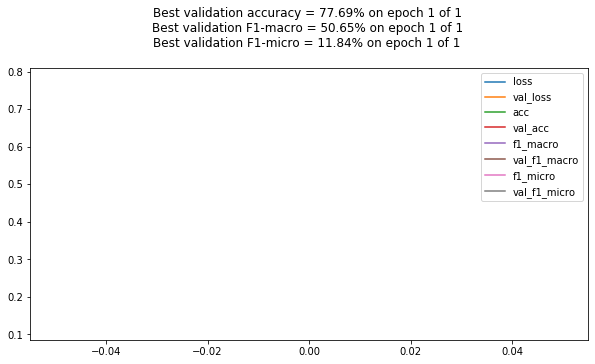

3582/3582 [==============================] - 134s 37ms/sample - loss: 0.5499 - acc: 0.7658 - f1_macro: 0.5469 - f1_micro: 0.1580 - val_loss: 0.5622 - val_acc: 0.7769 - val_f1_macro: 0.5065 - val_f1_micro: 0.1184


In [35]:
model.fit(X_tra, y_tra, 
          epochs=1, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True)
          ])

### Load the best Model

In [36]:
model_name

'RQ1_test_bert_model_8_tunedlayers_3_Adam_lr_2e-05_loss_binary_crossentropy'

In [37]:
best_model = model

### Evaluation

In [38]:
def get_scores(model, data_, batch_size, max_seq_length, 
               results_file=None, print_out=False):
    
    X, y_true = get_input(data_, max_seq_length)
    y = [y[0] for y in y_true]
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = [round(y[0]) for y in y_preds]
    
    clsrpt = classification_report(y_true, y_preds)
    sfm = scikit_f1_score(y_true, y_preds, average='macro')
    
    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')
            
    return sfm

#### Validation Set

In [39]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, max_seq_length, results_file, print_out=True)

Converting examples to features: 100%|██████████| 399/399 [00:00<00:00, 2476.37it/s]


              precision    recall  f1-score   support

           0       0.76      0.98      0.86       269
           1       0.89      0.36      0.51       130

   micro avg       0.78      0.78      0.78       399
   macro avg       0.82      0.67      0.68       399
weighted avg       0.80      0.78      0.74       399


Scikit_F1_Macro: 0.6844728775156603


#### Test Set

In [40]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, max_seq_length, results_file, print_out=True)

Converting examples to features: 100%|██████████| 441/441 [00:00<00:00, 2221.97it/s]


              precision    recall  f1-score   support

           0       0.79      0.98      0.88       325
           1       0.85      0.28      0.43       116

   micro avg       0.80      0.80      0.80       441
   macro avg       0.82      0.63      0.65       441
weighted avg       0.81      0.80      0.76       441


Scikit_F1_Macro: 0.6516927718862315


# Oylesine birden alinan sonuclar

##### Validation

In [41]:
y_val_true = np.array([sentence['label'] for article in valid_data 
                                 for sentence in article['sentences']])

y_val_preds = model.predict(X_val, batch_size=32)
y_val_preds = np.argmax(y_val_preds, axis=1)

print(classification_report(y_val_true, y_val_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_val_true, y_val_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       269
           1       0.73      0.87      0.80       130

   micro avg       0.85      0.85      0.85       399
   macro avg       0.83      0.86      0.84       399
weighted avg       0.87      0.85      0.86       399



In [44]:
scikit_f1_score(y_val_true, y_val_preds,average='macro')

0.841467090480627

##### Test

In [48]:
y_preds = model.predict(X_test, batch_size=32)
y_preds = np.argmax(y_preds, axis=1)

In [49]:
### build_flat_model_1 results
print(classification_report(y_test, y_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_test, y_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       325
           1       0.75      0.78      0.76       116

   micro avg       0.87      0.87      0.87       441
   macro avg       0.83      0.84      0.84       441
weighted avg       0.88      0.87      0.87       441



In [50]:
scikit_f1_score(y_test, y_preds, average='macro')

0.8388746803069054